<h1>The Illustrated Transformer - Attention is all you need</h1>

The Transformer was proposed in the paper Attention is All You Need [[1]](#ref1). The impact of this paper has been tremendous. It paved the way for a new generation of models such as BERT, GPT-2/3/4, T5, and others, which have achieved state-of-the-art results on a wide range of NLP tasks, including machine translation, text summarization, and sentiment analysis. These models, based on the Transformer architecture, have pushed the boundaries of what's possible with NLP, making applications like real-time translation, automatic content generation, and advanced chatbots a reality.

In this notebook we will attempt to recreate the “annotated” version of the paper in the form of a line-by-line implementation. We will be using several resources to aid our task:
 - The Illustrated Transformer by Jay Alammar [[2]](#ref2)
 - Harvard’s NLP group created a guide annotating the paper with PyTorch implementation [[3]](#ref3)


The key idea behind the Transformer is the self-attention mechanism, which computes a weighted sum of all words in a sentence for each word, where the weights are determined by the compatibility of the word with all others.

This model eliminated the need for recurrence and convolution, which were the dominant paradigms in the field up until then, and it allowed for much more parallelizable training, significantly reducing training times. It also improved the handling of long-term dependencies in text, a notorious difficulty with previous models.



<h2>Import Libraries</h2>

In [1]:
#import libraries
from IPython.display import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torchsummary import summary
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
import altair as alt
seaborn.set_context(context="talk")
%matplotlib inline

/Users/mammej/opt/anaconda3/envs/LLM/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h3>Helper Functions</h3>

In [2]:
class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None
        
class DummyScheduler:
    def step(self):
        None

<h2>Model Architecture</h2>

The majority of leading neural sequence transduction models utilize an encoder-decoder framework [[4]](#ref4). They typically employ Recurrent Neural Networks (RNNs) for both encoding and decoding phases. In this setup, the encoder transforms an input series of symbolic representations (x<sub>1</sub>, ..., x<sub>n</sub>) into a continuous ixed-length vector representation, z = (z<sub>1</sub>, ..., z<sub>n</sub>).This vector encapsulates the contextual information of the input. Utilizing z, the decoder subsequently produces an output series (y<sub>1</sub>, ..., y<sub>m</sub>) of symbols, generating each symbol individually [[Figure 1]](#fig1). This RNN-based framework enables the model to tackle tasks like machine translation, transforming input sequences into output sequences with potentially different lengths and structures, while preserving the temporal dependencies within the sequences. 

The model is auto-regressive at each stage [[5]](#ref5), using previously generated symbols as supplementary input for the production of the next symbol. Recurrent models, like RNNs, process sequences one piece at a time. They do this by creating a 'hidden state' for each piece based on the 'hidden state' of the piece before it and the current piece itself. This means that to understand the fifth piece of a sequence, the model first needs to understand the first four parts, one after the other. The step-by-step nature of RNNs doesn't allow for processing multiple parts of a sequence simultaneously within a single training example. As discussed in the original paper, Transformers eschews the recurrence and instead relying entirely on an attention mechanism to draw global dependencies between input and output leading to significantly more parallelization

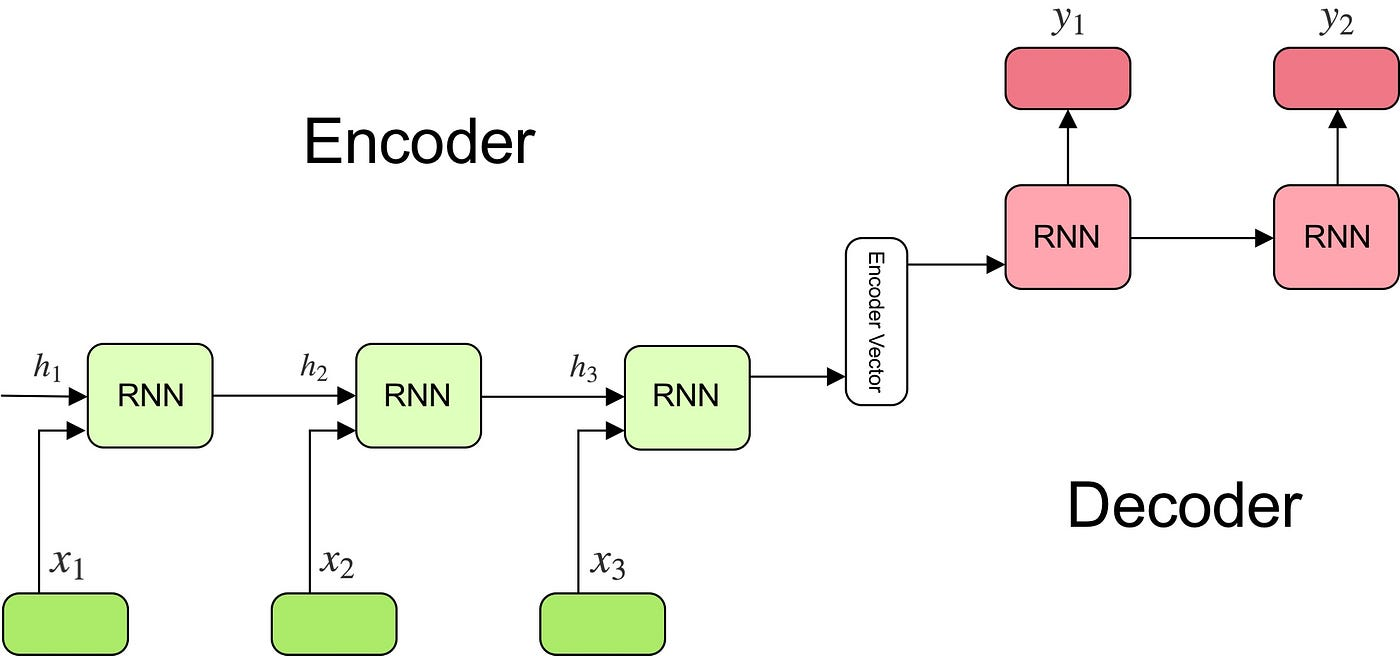

In [3]:
Image(filename='images/encode_decoder.png')

<a id="fig1">Figure 1</a>. Typical encode-decoder model structure in transduction models. (source: <a href="https://towardsdatascience.com/understanding-encoder-decoder-sequence-to-sequence-model-679e04af4346">Understanding Encoder-Decoder Sequence to Sequence Model</a>)

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the left and right halves of [Figure 2](#fig2), respectively.

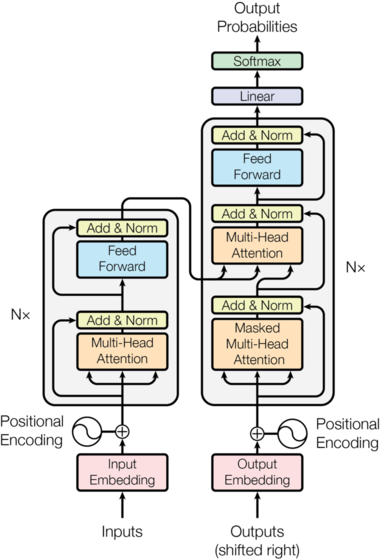

In [4]:
Image(filename='images/transformer_architecture.png')

<a id="fig2">Figure 2</a>. Transformer architecture model. (source: Vaswani et al., 2017 [[1]](#ref1))

<h3>Encoder and Decoder Stacks</h3>

<b style='color:red'>Encoder:</b> The encoder is composed of a stack of N = 6 identical layers. Each layer has two
sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, positionwise fully connected feed-forward network. We employ a residual connection [11] around each of
the two sub-layers, followed by layer normalization [1]. That is, the output of each sub-layer is
LayerNorm(x + Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer
itself. To facilitate these residual connections, all sub-layers in the model, as well as the embedding
layers, produce outputs of dimension dmodel = 512.

<b style='color:blue'>Decoder:</b> The decoder is also composed of a stack of N = 6 identical layers. In addition to the two
sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head
attention over the output of the encoder stack. Similar to the encoder, we employ residual connections
around each of the sub-layers, followed by layer normalization. We also modify the self-attention
sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This
masking, combined with fact that the output embeddings are offset by one position, ensures that the
predictions for position i can depend only on the known outputs at positions less than i.

[Figure 3](#fig3) depicts the encoder and decoder sublayer networks within the Tranformer model.

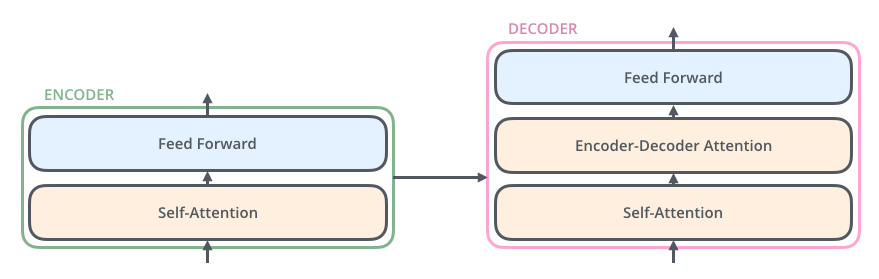

In [5]:
Image(filename='images/encoder_decoder_transformer.png')

<a id="fig3">Figure 3</a>. Encoder and Decoder sublayers in transformer model. (source: Alammar, J. 2018 [[2]](#ref2))

1. `clones` function

The encoder and decoder each is composed of a stack of N = 6 identical layers. The clones function is used to create multiple identical copies of a layer. In this case, it's creating N=6 clones of the given module.

In [6]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

2. `class Encoder`

We will be defining a new class called `Encoder`, which is a subclass of the `nn.Module` class from PyTorch. By subclassing this, we're saying that our `Encoder` class is a type of neural network module. It takes three arguments: `self` (which is a reference to the instance of the class), `layer` (which is some layer of the network), and `N` (which is the number of times that layer should be repeated in the encoder) since the architecture of the original transformer model in the paper involves repeating the same layer N=6 times. 

The next line is creating an instance of layer normalization. Layer normalization is a type of normalization technique that normalizes the features of a layer at each level. Next we will create a class for `LayerNorm`.

In the forward function the loop passes the input `x` and the mask through each layer in turn. The output of each layer then becomes the input for the next one. After the input has been passed through all the layers, it is then normalized before being outputted.

This Encoder class is a fundamental part of the Transformer model architecture and is used to process the input before it's sent to the Decoder.

In [7]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N): 
        super(Encoder, self).__init__() # super() lets you ensure that any important initialization done there is carried over to our subclass.
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask): # forward propagation function for the encoder.
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x) # After the input has been passed through all the layers, it is then normalized before being outputted.


3. `class LayerNorm`

We define a new class called `LayerNorm`, which is a subclass of the `nn.Module`. `LayerNorm` class accepts `features` (the number of input features to normalize) and `eps` (a small constant added to the denominator for numerical stability).

Next we initialize two learnable parameters, `a_2` and `b_2`, to vectors of ones and zeros of size equal to features respectively. These parameters correspond to the <b>scale</b> and <b>shift</b> parameters in the layer normalization formula.

Inside the forward propogation function we calculate the mean and standard deviation of the input `x` along the last dimension, while keeping the dimensions of the output the same as the input.

Lastly, the class returns the main part of the layer normalization process. It normalizes the input `x` by subtracting the mean and dividing by the standard deviation (plus a small constant eps for numerical stability). Then, it scales (multiplies) and shifts (adds) the result by the learned parameters `a_2` and `b_2` before returning it.


In [8]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6): # eps is a value added to the denominator for numerical stability
        super(LayerNorm, self).__init__() # this line calls the initializer of the LayerNorm's parent class (nn.Module).
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

4. `class SublayerConnection`

The `SublayerConnection` class is used to add both the <b><u>residual connections</u></b> [[6]](#ref6) and the <b><u>layer normalization</b></u> [[7]](#ref7) around each of the two sub-layers to simplify the Transformer's architecture. Residual connections help to avoid the problem of vanishing gradients during training, and layer normalization helps to stabilize the learning process and speeds up convergence.

We define a new class called `SublayerConnection`, which is a subclass of `nn.Module`. It accepts `size` (the dimensionality of the input) and `dropout` (the dropout rate).

After performing layer normalization as described previously, we apply `dropout` to inputs. Dropout is a regularization technique where randomly selected neurons are ignored during training [[8]](#ref8). 

In the forward propagation function we first normalize the input `x` using `self.norm(x)`, then apply the sublayer function and dropout. Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed- forward network. The output of all this is then added to the original input `x` to form a <u>residual connection</u>. This is why it's called a "SublayerConnection": it applies a sublayer to the normalized input, and then combines the output with the original input.

In [9]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, d_model, dropout):
        super(SublayerConnection, self).__init__() #initializer of parent class.
        self.norm = LayerNorm(d_model) # LayerNorm object
        self.dropout = nn.Dropout(dropout) # dropout object

    def forward(self, x, sublayer):  # forward propagation function
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x))) # residual connection is applied to the output of the sublayer.

5. `class EncoderLayer`

As described earlier each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed- forward network. Overall, this layer follows the description of an encoder layer in the original "Attention is All You Need" [[1]](#ref1) paper, with self-attention and feed-forward operations, as well as the necessary residual connections and layer normalization.

The init function accepts four inputs: 
- `size`: the expected size of the input tensors
- `self_attn`: the attention mechanism to use (usually, multi-head self-attention)
- `feed_forward`: the feed-forward network to use
- `dropout`: the probability of dropping out neurons during training

The forward propogation receives `x` (the input tensor) and `mask` (to be used during the attention computation).

First, it applies the self-attention to `x` (notice that x is used three times here because in self-attention, <u>queries, keys, and values</u> all come from the same place). The self-attention operation is wrapped inside a lambda function to conform to the interface of SublayerConnection. The result is then fed into the first sub-layer connection, which applies layer normalization, the sublayer itself (i.e., self-attention here), and the residual connection in that order.

Second, it applies the feed-forward network to the output of the first sublayer connection. This output is then passed through the second sublayer connection, which again applies the layer normalization, the sublayer itself (i.e., the feed-forward network here), and the residual connection in that order.

In [10]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn # self attention object
        self.feed_forward = feed_forward # feed forward object
        self.sublayer = clones(SublayerConnection(size, dropout), 2) # sublayer connection object with layer normalization and residucal connection.
        # self.dropout = dropout # dropout object
        self.size = size
        
    # def forward(self, x, mask):
    #     "Follow Figure 2 (left) for connections."
    #     attn_output = self.self_attn(x, x, x, mask) # self attention is applied to the input.
    #     x = self.sublayer[0](x + self.dropout(attn_output)) # first sublayer - self attention is applied to the input.
    #     ff_output = self.feed_forward(x) # feed forward is applied to the output of the first sublayer.
    #     x = self.sublayer[1](x + self.dropout(ff_output)) # second sublayer - feed forward is applied to the output of the first sublayer.
    #     return x
    
    def forward(self, x, mask):
        "Follow Figure 2 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

6. ` class Decoder`

The decoder is also composed of a stack of N = 6 identical layers.

Initialization function accepts two inputs: 
- `layer`: a single layer of the decoder (usually composed of self-attention, cross-attention, and feed-forward layers)
- `N`: the number of layers in the decoder

The decoder is constructed by making N clones of the layer. It also initializes a LayerNorm layer, which is used to normalize the output of the last layer.

The forward function takes four arguments:

- `x`: the input tensor (for the first Decoder layer, x would be the embedded representations of the target sequence (plus positional encodings), for middle and last Decoder layer is represent the output of the previous Decoder layer)
- `memory`: the output of the encoder (used in the cross-attention layer)
- `src_mask`: a mask applied to the input of the encoder to ignore certain parts of the input (like padding)
- `tgt_mask`: a mask applied to the input of the decoder to prevent attending to future positions (this is required because the decoder is supposed to be auto-regressive) 

In the forward function, the input `x` and the `memory` output from the `Encoder` are passed through each layer in turn. Each layer computes its own output, which serves as the input to the next layer. The final layer output is then normalized by the LayerNorm layer to produce the final Decoder output.


In [11]:

class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)  # clones the layer N times.
        self.norm = LayerNorm(layer.size)   # layer normalization object.
    
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)   # passes the input through each layer.
        return self.norm(x)

7. `class DecoderLayer`

In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.

The initializer for the DecoderLayer class takes as input parameters the size of the model, the self-attention mechanism, the source-attention mechanism, the feed-forward network, and the dropout rate. 
- `self.size`: holds the size of the input vectors.
- `self.self_attn`: is a multi-head self-attention mechanism that helps the decoder focus on appropriate places in the input sequence.
- `self.src_attn`: is another multi-head attention mechanism that helps the decoder focus on appropriate places in the output sequence from the encoder (referred to as 'memory' in this code).
- `self.feed_forward`: is a position-wise feed-forward network, which is applied to each position separately and identically. It consists of two linear transformations with a ReLU activation in between.
- `self.sublayer`: creates three copies of a `SublayerConnection` object (which is a residual connection followed by layer normalization). These will be used to implement the connections as shown in the Transformer's architecture.

The forward propogation first creates a variable `m` that holds the output of the encoder. The first sublayer performs self-attention on the input `x`. This self-attention allows the model to associate each word in the input sequence with every other word in the same sequence to better understand the context. The `tgt_mask` is used to prevent the model from attending to future positions during training (because the model should predict each position based only on previous positions).
The second sublayer performs attention over the output of the encoder (i.e., m). This helps the decoder to focus on relevant parts of the input sentence.
The final sublayer is the position-wise feed-forward network.
The output of the final sublayer is then returned. It should be noted that these operations are performed in sequence: the output of one layer is used as input to the next.


In [12]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        # self.dropout = dropout
        self.size = size
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 2 (right) for connections."
        # attn_output = self.self_attn(x, x, x, tgt_mask) # self attention is applied to the input x.
        # x = self.sublayer[0](x + self.dropout(attn_output)) # first sublayer - self attention is applied to the input.
        # attn_output = self.src_attn(x, memory, memory, src_mask) # source attention is applied to the output of the first sublayer.
        # x = self.sublayer[1](x + self.dropout(attn_output)) # second sublayer - source attention is applied to the output of the first sublayer.
        # ff_output = self.feed_forward(x) # feed forward is applied to the output of the second sublayer.
        # x = self.sublayer[2](x + self.dropout(ff_output)) # third sublayer - feed forward is applied to the output of the second sublayer.
        # return x
        
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)
        

8. `subsequent_mask` function

As discussed in the original paper [[1]](#ref1) 

<figure class="quote", style='border-left: 5px solid #66e4b4;'><blockquote>We modify the self-attention sub-layer in the decoder stack to <i><u>prevent positions from attending to subsequent positions</u></i>. This masking, combined with fact that <i><u>the output embeddings are offset by one position</u></i>, ensures that the predictions for position <em>i</em> can depend only on the known outputs at positions less than <em>i</em>.</blockquote>
<figcaption style='font-style: italic; text-align: right'>&mdash; <cite>"Attention is all you need"</cite> </figcaption></figure>

In simple terms, this refers to the property of the transformer decoder to only pay attention to earlier positions in the output sequence when predicting the next word. This is known as "autoregression"[[5]](#ref5) and it models the idea that each word you generate in a sentence is dependent on the words you've already generated.

For instance, imagine you're translating a sentence from English to French. You've already translated the first three words, and you're working on the fourth. When predicting this fourth word, you only want your model to consider the first three words you've already translated (known outputs) and not any of the words that come after (since you haven't translated them yet).

This is achieved in the transformer decoder by applying a mask to the input, effectively blocking (or "masking out") future information.


The second part about "output embeddings are offset by one position" is the way this autoregressive property is implemented: when training the model, the target inputs to the decoder are the expected outputs, but they are shifted one position to the right. This means that the model doesn't have access to the current target word when predicting it, enforcing the condition that predictions can only depend on known outputs.  In the context of the Transformer model, when we're training, we use a technique called "teacher forcing" where the target sequence itself is used as an input to the model. But we don't want the model to 'see' the future words in this sequence.

So, imagine our target sentence is "I love dogs". In the decoder part of the transformer, we would shift this sentence by one position, resulting in "_ I love", with _ denoting a blank start token. The model would then predict the first word "I" with only the start token as context, predict "love" with "I" as context, and "dogs" with "I love" as context. The model isn't allowed to 'see' the future, it can only make its predictions based on what it's seen so far. This way, we are making sure the model's prediction for a certain position is only depending on known outputs at positions less than the current one.

When training a sequence-to-sequence model such as a Transformer, we typically use a special token to signal the start and end of a sentence. For example, we might use "&lt;sos&gt;" (start of sentence) and "&lt;eos&gt;" (end of sentence) tokens.

So the correct process would look like this:

- "&lt;sos&gt;"
- "&lt;sos&gt; I"
- "&lt;sos&gt; I love"
- "&lt;sos&gt; I love dogs"

At each step, the model would predict the next word. The "&lt;sos&gt;" token is used as a signal to the model that this is the start of a new sentence, and it should start generating the next word.

In [13]:
def subsequent_mask(seq_length):
    "Mask out subsequent positions."
    attn_shape = (1, seq_length, seq_length)  # creates a 3D array of 1 x size x size.
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')   # creates a triangular matrix of 1s. attn_shape = (1, size, size) and k = 1 means that the diagonal and the lower triangle will be zero.
    return torch.from_numpy(subsequent_mask) == 0  # returns a tensor of 0s and 1s where the triangular matrix of 1s is 0 and the rest is 1.

Below the attention mask shows the position each target word (row) is allowed to look at (column). Words are blocked for attending to future words during training.

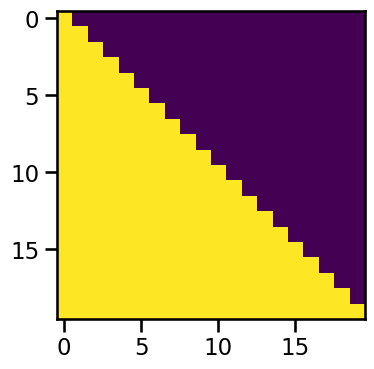

In [14]:
plt.figure(figsize=(4,4))
plt.imshow(subsequent_mask(20)[0])


<h3>Attention</h3>

<figure class="quote", style='border-left: 5px solid #66e4b4;'><blockquote>An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.</blockquote>
<figcaption style='font-style: italic; text-align: right'>&mdash; <cite>"Attention is all you need"</cite> </figcaption></figure>


The particular attention used in the original paper is called “Scaled Dot-Product Attention” [Figure 4](#fig4) where input consists of queries and keys of dimension d<sub>k</sub>, and values of dimension d<sub>v</sub>. We compute the dot products of the query with all keys, divide each by √d<sub>k</sub>, and apply a softmax function to obtain the weights on the values.

$$ \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$

where: 
- $ Q $ - the set of queries packed together into a matrix.
- $ K $ - the set of keys packed together into a matrix.
- $ V $ - the set of values packed together into a matrix.
- $ T $ - transpose
- $ d_k $ - dimensions for queries and keys (which is model dimension divided by number of transformer heads)
- $ d_v $ - dimensions for values (which is model dimension divided by number of transformer heads)
- $ \text{softmax} $ - a mathematical function that converts a vector of numbers into a vector of probabilities, where the probabilities of each value are proportional to the relative scale of each value in the vector (summing to 1)

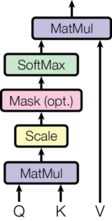

In [15]:
Image(filename='images/scaled_dot_product.png')

<a id="fig4">Figure 4</a>. Scaled Dot-Product Attention. (source: Vaswani et al., 2017 [[1]](#ref1))

<h3>Attention function</h3>
The original paper discusses the most commonly used attention functions: additive attention and dot-product (multiplicative) attention. While for small values of d<sub>k</sub> the two mechanisms perform similarly, additive attention outperforms dot product attention. To counteract this effect, the dot products is scaled by $1/\sqrt{d_k}$.

`attention` function

The attention function  takes as input the query, key, and value vectors, an optional mask, and an optional dropout rate. After getting the dimension of the query we the raw attention scores by taking the dot product of the query and key vectors (after transposing the last two dimensions of the key tensor for correct alignment). The result is then scaled down by dividing by the square root of the dimensionality of the key vector (this is the "scale" part of the "Scaled Dot Product Attention").

If a mask is provided, it is applied to the attention scores. The mask is typically used to prevent the model from attending to certain positions (like padding positions). Here, the masking is performed by replacing the scores at the masked positions with a very large negative value (-1e9), effectively pushing the softmax value close to zero.

Next we apply a softmax function to the scores to convert them into attention probabilities (each between 0 and 1, and summing to 1 across each row).

If a dropout rate is provided, dropout is applied to the attention probabilities. This is a regularization technique to prevent overfitting.

Finally, the output is computed by taking a weighted sum of the value vectors, with the weights being the attention probabilities. The function also returns the attention probabilities for possible further analysis or visualization.

This function implements the core attention mechanism of the Transformer model, as described in the "Attention is All You Need" paper [[1]](#ref1). The idea is to compute a weighted sum of the value vectors, where the weight assigned to each value depends on how well the corresponding key matches the query.


In [16]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)   # gets the dimension of the query.
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
             # .transpose(-2, -1) transposes the last two dimensions of the tensor.
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9) 
    p_attn = F.softmax(scores, dim = -1) # softmax function to the scores to convert them into attention probabilities (each between 0 and 1, and summing to 1 across each row).
    if dropout is not None:
        p_attn = dropout(p_attn) # dropout is applied to the attention probabilities. This is a regularization technique to prevent overfitting.
    return torch.matmul(p_attn, value), p_attn # returns the attention probabilities and the attention output.

<h3>Multi-Head Attention</h3>


<figure class="quote", style='border-left: 5px solid #66e4b4;'><blockquote>Instead of performing a single attention function with dmodel-dimensional keys, values and queries, we found it beneficial to linearly project the queries, keys and values <i>h</i> times with different, learned linear projections to d<sub>k</sub>, d<sub>k</sub> and d<sub>v</sub> dimensions, respectively. On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding d<sub>v</sub>-dimensional output values.</blockquote>
<figcaption style='font-style: italic; text-align: right'>&mdash; <cite>"Attention is all you need"</cite> </figcaption></figure>

[Figure 5](#fig5) depicts how the individual heads (with projected versions of queries, keys and values) are concatenated and once again projected, resulting in the final values.

The concept of Multi-head Attention is like having multiple "perspectives" or "interpretations" when looking at a sentence. Each head learns to focus on different parts of the sentence and thus captures various aspects of the information in the sentence.

To achieve this, instead of applying attention once (which can be seen as a single 'viewpoint'), the model applies attention multiple times in parallel. Each application of attention is known as a 'head'. Hence the term 'multi-head attention'.

The intuition here is that different heads could learn to focus on different types of relationships. For instance, one head might learn to pay attention to the subject in a sentence, another might focus on a verb, and so on. This provides a richer representation of the sentence than using a single head and hence can lead to better performance.

For a concrete example, consider the sentence "The cat sat on the mat". One attention head might pay more attention to "cat", another head might focus more on "sat", and so forth. This way, the model can create a more nuanced understanding of the sentence. </br><br>

$$ MultiHead(Q, K, V) = Concat(\text{head}_1, ..., \text{head}_h)W_O\\ $$
where,
$$ \text{head}_i = \text{Attention}(QW^{Q}_{i}, KW^{K}_{i}, VW^{V}_{i}) $$

In the original paper the authors employ h = 8 parallel attention layers, or heads. For each of these they use $ d_k = d_v = d_{model}/h = 64 $. Due to the reduced dimension of each head, the total computational cost
is similar to that of single-head attention with full dimensionality.



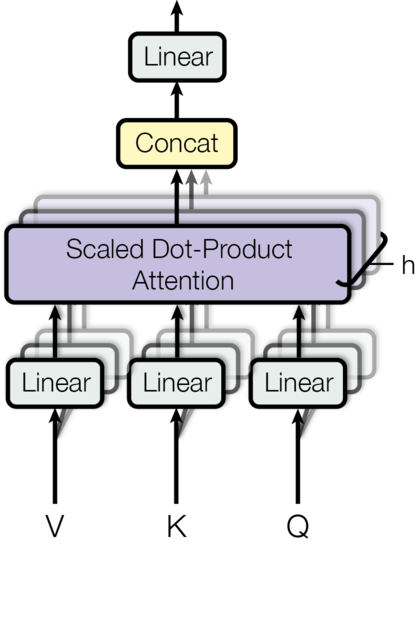

In [17]:
Image(filename='images/Multi_head_transformer.png')

<a id="fig5">Figure 5</a>. Multi-Head Attention consisting of several attention layers running in paralleln. (source: Vaswani et al., 2017 [[1]](#ref1))

`class MultiHeadedAttention`

The initialization method for the class takes in the number of attention heads (`h`), the model dimension (`d_model`), and an optional `dropout` rate.

- `self.d_k = d_model // h` sets the dimension of the keys, queries, and values in each of the attention heads.
- `self.attn` is used to store the attention weights for visualization or debugging purposes.
- `self.dropout` specifies a dropout layer with dropout probability dropout.
- `W_q`, `W_k`, `W_v` and `W_o` are identical linear transformation layers with input and output dimensions of d_model. These transformations are essentially matrices that are learned during training, and they are used to project the input vectors into different representational spaces. The first three Linear layers are used for transforming the input to the attention mechanism into the so-called "query" ($Q$), "key" ($K$), and "value" ($V$) representations. The last Linear layer `W_o` is the output linear layer. After the attention scores are used to weigh the value vectors, the resulting context vector is passed through this output linear layer. This serves to transform the context vector back to the original input dimension (`d_model`) so that it can be further processed by the subsequent layers in the Transformer model.

The `split_heads` method reshapes the input tensor `x` to separate the different attention heads. It takes a tensor of shape `[batch_size, seq_length, d_model]` and reshapes it to `[batch_size, h, seq_length, d_k]`, where `h` is the number of attention heads and `d_k` is the dimensionality of each head. This operation effectively creates `h` separate "views" of the input data.

The `combine_heads` method does the reverse of split_heads. It takes a tensor of shape `[batch_size, h, seq_length, d_k]` and reshapes it back to `[batch_size, seq_length, d_model]`, combining the separate attention heads back into a single representation.

The `forward` method carries out the main computation. It first applies the `W_q`, `W_k`, and `W_v` linear transformations to the `query`, `key`, and `value` inputs, respectively. These transformed inputs are then reshaped using `split_heads` to create separate views for each attention head. An attention function is then applied to these views. The attention function computes scaled dot-product attention. The result is reshaped back to its original shape using `combine_heads`, and the `W_o` linear transformation is applied to produce the final output. The attention weights are stored in `self.attn` for later analysis.

Again, key idea behind multi-head attention is to allow the model to focus on different positions (in the case of self-attention) or different parts of the input (in the case of encoder-decoder attention) for each head, capturing various aspects of the input.


In [18]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )

        # 3) "Concat" using a view and apply a final linear.
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(nbatches, -1, self.h * self.d_k)
        )
        del query
        del key
        del value
        return self.linears[-1](x)

In [19]:
# class MultiHeadedAttention(nn.Module):
#     def __init__(self, h, d_model, dropout=0.1):
#         super(MultiHeadedAttention, self).__init__()
#         assert d_model % h == 0 # check that the model size is divisible by the number of attention heads.
        
#         self.d_model = d_model
#         self.h = h
#         self.d_k = d_model // h
#         self.attn = None
#         self.dropout = nn.Dropout(p=dropout)
        
#         self.W_q = nn.Linear(d_model, d_model)
#         self.W_k = nn.Linear(d_model, d_model)
#         self.W_v = nn.Linear(d_model, d_model)
#         self.W_o = nn.Linear(d_model, d_model)
        
#     def split_heads(self, x):
#         batch_size, seq_length, self.d_model = x.size()
#         return x.view(batch_size, seq_length, self.h, self.d_k).transpose(1, 2)
        
#     def combine_heads(self, x, batch_size):
#         # batch_size, _, seq_length, self.d_k = x.size()
#         # return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
#         return x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)
        
#     def forward(self, query, key, value, mask=None):
        
#         if mask is not None:
#             # Same mask applied to all h heads.
#             mask = mask.unsqueeze(1)
#         nbatches = query.size(0)
        
#         query = self.split_heads(self.W_q(query))
#         key = self.split_heads(self.W_k(key))
#         value = self.split_heads(self.W_v( value))
        
#         x, self.attn = attention(
#             query, key, value, mask=mask, dropout=self.dropout
#             )
        
#         output = self.W_o(self.combine_heads(x, nbatches))
        
#         del query
#         del key
#         del value
#         return self.W_o(output)

NOTE:<br>
Now, let's consider the case where these linear layers are applied to the `query`, `key`, and `value` tensors. Suppose the original size of each of these tensors is `[nbatches, seq_len, d_model]`, where `seq_len` is the sequence length.

After passing through the linear layers, the size of each tensor remains `[nbatches, seq_len, d_model]`, since each linear layer maps `d_model` to `d_model`.

The `.view(nbatches, -1, self.h, self.d_k)` operation reshapes each tensor to have size `[nbatches, seq_len, self.h, self.d_k]`. Since `self.h * self.d_k = d_model`, this operation is essentially breaking down the last dimension of the tensor into two smaller dimensions. In the case where `self.h` = 8 and `d_model` = 512, `self.d_k = d_model / self.h` = 64.

The `.transpose(1, 2)` operation then swaps the second and third dimensions of each tensor, resulting in tensors of size `[nbatches, self.h, seq_len, self.d_k]`. This is done to make sure that the dimensions align properly for the upcoming operations (such as scaled dot product attention).

So, if `d_model` = 512, `self.h` = 8, and `self.d_k` = 64, the tensors will be reshaped from `[nbatches, seq_len, 512]` to `[nbatches, 8, seq_len, 64]`. Each of the 8 "heads" will now have its own set of `seq_len` vectors of size 64 to perform the scaled dot-product attention on.

<h3>Applications of Attention in our Model</h3>

<figure class="quote", style='border-left: 5px solid #66e4b4;'><blockquote>The Transformer uses multi-head attention in three different ways: 

1) In “encoder-decoder attention” layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder. This allows every position in the decoder to attend over all positions in the input sequence. This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models such as (cite).

2) The encoder contains self-attention layers. In a self-attention layer all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder. Each position in the encoder can attend to all positions in the previous layer of the encoder.

3) Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position. We need to prevent leftward information flow in the decoder to preserve the auto-regressive property. We implement this inside of scaled dot- product attention by masking out (setting to −∞) all values in the input of the softmax which correspond to illegal connections.</blockquote>
<figcaption style='font-style: italic; text-align: right'>&mdash; <cite>"Attention is all you need"</cite> </figcaption></figure>



<h3>Position-wise Feed-Forward Networks</h3>

<figure class="quote", style='border-left: 5px solid #66e4b4;'><blockquote>In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.

$$ \text{{FFN}}(x) = \max(0, xW_1 + b_1)W_2 + b_2 $$

While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1. The dimensionality of input and output is d<sub>model</sub> = 512, and the inner-layer has dimensionality d<sub>ff</sub> = 2048.

</blockquote>
<figcaption style='font-style: italic; text-align: right'>&mdash; <cite>"Attention is all you need"</cite> </figcaption></figure>


Linear Transformation is a simple multiplication of the input vector with a weight matrix, followed by adding a bias vector. This transformation changes the dimension of the vector. If the input vector is of size `d_model`, it will be transformed to size `d_ff` (where dff is a hyperparameter and usually d<sub>ff</sub> >> d<sub>model</sub>).
`ReLU` is an element-wise activation function, which will output the input directly if it is positive; otherwise, it will output zero.

The point-wise fully connected layer, or the feed-forward neural network (FFN), is an essential component in the Transformer model. It serves several key functions:

1. **Non-linearity**: The Transformer relies heavily on linear operations - specifically, the self-attention mechanism and layer normalization are linear in nature. The point-wise fully connected layers introduce non-linearity into the model, which is crucial for learning complex patterns and relationships.
2. **Increased Model Capacity**: The point-wise fully connected layer consists of two linear layers (with a ReLU activation in between), which increases the capacity of the model without introducing too much complexity in terms of connections between different positions in the sequence. This increased capacity allows the Transformer to learn more complex relationships.
3. **Feature Transformation**: Each of the linear layers in the FFN transforms the feature representation of each position in the sequence. This can be thought of as providing the model with an additional opportunity to transform and combine the features learned by the self-attention mechanism.
4. **Parallel Computation**: Since the FFN is applied independently to each position, these operations can be efficiently computed in parallel, which is a property that aligns well with modern hardware accelerators.
5. **Depth to the Network**: The FFN adds depth to the Transformer architecture, which can help the model learn hierarchical features.

So, while the self-attention mechanism allows the model to consider other words in the sequence when encoding a particular word, the point-wise fully connected layer gives the model a chance to consider each word independently. This mixture of "global" (via self-attention) and "local" (via FFNs) consideration allows the Transformer to effectively handle complex patterns in the data.

`class PositionwiseFeedForward`

The PositionwiseFeedForward takes in two arguments (`d_model` and d_ff`) and an optional dropout rate. The function initializes two linear layers `w_1` and `w_2` with respective input-output dimensions, as well as a dropout layer. The forward function applies the first linear transformation to the input tensor `x`, followed by a `ReLU` (Rectified Linear Unit) activation function. The output of this activation function is then passed through the dropout layer for regularization, which randomly sets a fraction of input units to 0 at each update during training. Finally, the output from the dropout layer is passed through the second linear transformation and returned as the result.

In [20]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff) # first linear layer.
        self.w_2 = nn.Linear(d_ff, d_model) # second linear layer.
        self.dropout = nn.Dropout(dropout) # dropout object.

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x)))) # applies the first linear layer, followed by a ReLU activation function, dropout, and the second linear layer.

<h3>Embeddings and Softmax</h3>
<figure class="quote", style='border-left: 5px solid #66e4b4;'><blockquote>Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension d<sub>model</sub>. We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities. In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation, . In the embedding layers, we multiply those weights by √d<sub>model</sub>.
</blockquote>
<figcaption style='font-style: italic; text-align: right'>&mdash; <cite>"Attention is all you need"</cite> </figcaption></figure>

Utilizing the same weight matrix between the two embedding layers and the pre-softmax linear transformation is similar to the method discussed in the original "Using the Output Embedding to Improve Language Models" paper by Press and Wolf, 2016 [[9]](#ref9)

`class Embeddings`

The `Embeddings` class is initialized with two parameters: `d_model` - the dimension of the embedding, and `vocab` - the size of the vocabulary. An instance of the class creates an embedding table `self.lut` of size `[vocab, d_model]`. The forward function takes in an input `x` which represents indices of words in the vocabulary, retrieves the corresponding vectors from the lookup table `self.lut`, and scales these vectors by the square root of `d_model` (as recommended in the "Attention is All You Need" paper to balance the scale of the dot product in the multi-head attention mechanism).

In [21]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model) # Embedding object.
        self.d_model = d_model  # dimension of the embedding.

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model) # multiplies the embedding by sqrt(d_model) to scale the embeddings.

<h3>Positional Encoding</h3>

<figure class="quote", style='border-left: 5px solid #66e4b4;'><blockquote>
Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. To this end, we add “positional encodings” to the input embeddings at the bottoms of the encoder and decoder stacks. The positional encodings have the same dimension `d_model` as the embeddings, so that the two can be summed. 

In this work, we use sine and cosine functions of different frequencies:
$$ PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}}\right) $$ 
$$ PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}}\right) $$ 

where $pos$ is the position and $i$ is the dimension. That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from $2π$ to $10000 · 2π$. We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k, PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$.  We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.

</blockquote>
<figcaption style='font-style: italic; text-align: right'>&mdash; <cite>"Attention is all you need"</cite> </figcaption></figure>

In natural language, words have a sequence. The order of words in a sentence can completely change the meaning of the sentence. For example, "The cat ate the mouse" has a very different meaning from "The mouse ate the cat." In order to understand language properly, we need to understand the order of words.

However, when we convert words into numbers for machine learning models (a process called embedding), we lose that order information. All we have is a list of numbers, and we've lost the information about which word came first, which word came second, and so on.

This is where positional encoding comes in. The idea is to add more information to each word's numbers to give the model clues about the word's position in the sentence.

Despite the fact that actual way we calculate these position encodings may seem a bit tricky (it uses sine and cosine functions). The important thing to understand is that these calculations are designed to make sure that the position information is unique and meaningful for each word's position in the sentence, and can even handle sentences of different lengths.

In summary, these vectors follow a specific pattern that the model learns, which helps it determine the position of each word, or the distance between different words in the sequence. The intuition here is that adding these values to the embeddings provides meaningful distances between the embedding vectors once they’re projected into $Q$/$K$/$V$ vectors and during dot-product attention.

`class PositionalEncoding`

The initializer method for the class takes three arguments: `d_model` - (the dimension of the model), `dropout` - (the dropout rate), and `max_len` - (the maximum length for positional encoding). After initializing a tensor of zeros with size `[max_len, d_model]` to store the positional encodings, we create a tensor with values from 0 to `max_len` and adds an extra dimension with `unsqueeze(1)`, resulting in a tensor of size `[max_len, 1]`.

Next we compute the positional encoding. The values are computed for every second index up to `d_model`. The `exp` function applies the exponential function to the argument, effectively calculating `(1 / 10000^(2i/d_model))` for each `i` from 0 to `d_model/2`.

Next, we compute the sine and cosine of the positional encoding for the even and odd indices respectively. After adding an extra dimension at the beginning of the tensor, changing its shape from `[max_len, d_model]` to `[1, max_len, d_model]`, we register the tensor `pe` as a buffer, which means it becomes part of the model's state. PyTorch will track but not compute gradients for this tensor.

The forward pass of the module takes input tensor `x` is assumed to have shape `[batch_size, sequence_length, d_model]`. We add the positional encodings to the input tensor. The positional encodings tensor is sliced to match the sequence length of `x`. The `requires_grad_(False)` is used to ensure that no gradients are computed for the positional encodings during backpropagation.

Lastly, we apply the dropout to the tensor with the added positional encodings and returns the result.

In [22]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout) # dropout object.

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)  # initialize a tensor pe of shape [max_len, d_model] with zeros.
        '''create a tensor position of shape [max_len, 1] with values [0, 1, 2, ..., max_len - 1].'''
        position = torch.arange(0, max_len).unsqueeze(1) 
        '''create a tensor div_term of shape [d_model / 2] with values [10000^(-2i/d_model) for 
        i = 0, 1, 2, ..., d_model / 2 - 1].'''
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)) 
        # select every other element of the tensor pe starting from the first element.
        pe[:, 0::2] = torch.sin(position * div_term)
        # select every other element of the tensor pe starting from the second element.
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # add a dimension of 1 to the tensor pe.
        '''register the tensor pe as a buffer of the module. Buffers are tensors whose values are not updated during training.
        This is important when we want to save and load our model.'''
        self.register_buffer("pe", pe)
    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False) # add the positional encoding to the input.
        return self.dropout(x) # apply dropout to the input.

Below the positional encoding will add in a sine wave based on position. The frequency and offset of the wave is different for each dimension.

In [23]:
RUN_EXAMPLES = True
def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)
    
def example_positional():
    pe = PositionalEncoding(20, 0)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )


show_example(example_positional)

alt.Chart(...)

<h3>EncoderDecoder Model</h3>

The `EncoderDecoder` class is an implementation of a general Encoder-Decoder architecture, which is a foundational structure for many sequence-to-sequence tasks in deep learning such as machine translation. It comprises an encoder, a decoder, source and target embedding layers, and a generator. The forward method orchestrates the data flow through the architecture: it first encodes the input (source) sequence, using both the input sequence and its corresponding mask. It then decodes the resulting memory, using the memory, source mask, target sequence, and target mask. The encode and decode methods handle the encoding of the source sequence and decoding of the target sequence respectively, each using their associated embeddings and masks. The output of the decoding process is then returned by the model.

In [24]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask) # passes the input through the encoder and decoder.

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

<h3>The Final Linear and Softmax Layer</h3>

The decoder stack outputs a vector of floats. How do we turn that into a word? That’s the job of the final Linear layer which is followed by a Softmax Layer.

The Linear layer is a simple fully connected neural network that projects the vector produced by the stack of decoders, into a much, much larger vector called a logits vector.

Let’s assume that our model knows 10,000 unique English words (our model’s “output vocabulary”) that it’s learned from its training dataset. This would make the logits vector 10,000 cells wide – each cell corresponding to the score of a unique word. That is how we interpret the output of the model followed by the Linear layer.

The softmax layer then turns those scores into probabilities (all positive, all add up to 1.0). The cell with the highest probability is chosen, and the word associated with it is produced as the output for this time step.

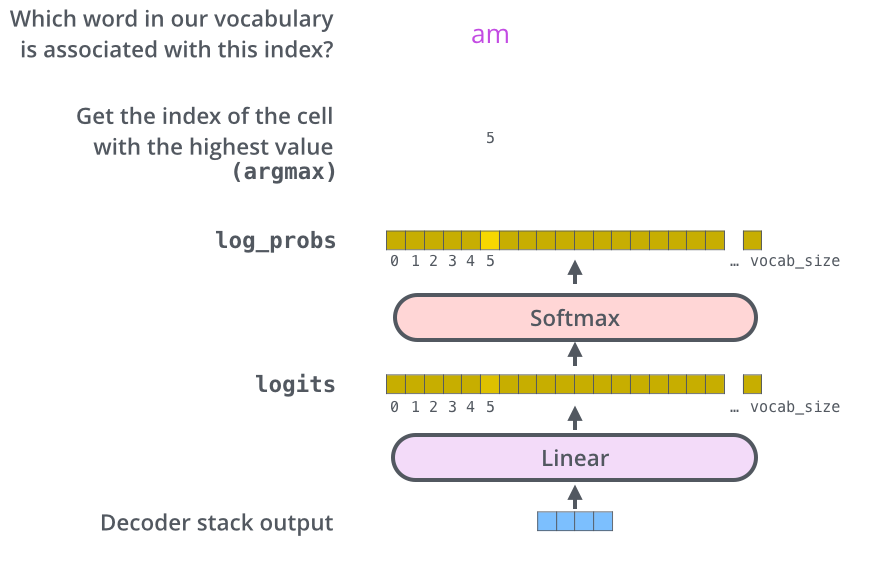

In [25]:
Image(filename='images/linear_softmax_layer.png')

<a id="fig6">Figure 6</a>. This figure starts from the bottom with the vector produced as the output of the decoder stack. It is then turned into an output word. (source: Alammar, J. 2018 [[2]](#ref2))

In [26]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, tgt_vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, tgt_vocab) # linear layer.

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1) # applies the linear layer followed by a softmax function.

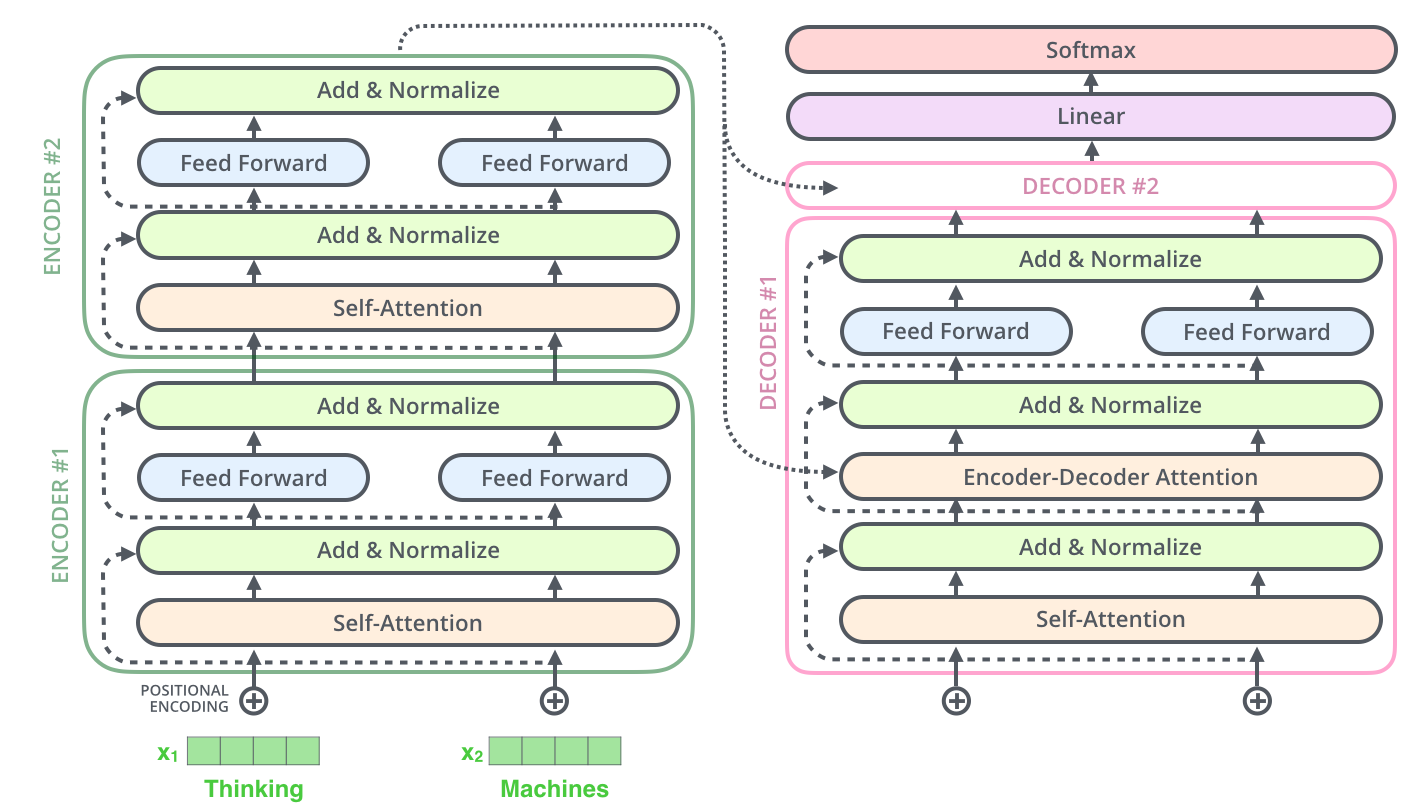

In [27]:
Image(filename='images/encoder_decoder_model.png')

<a id="fig7">Figure 7</a>. If we’re to think of a Transformer of 2 stacked encoders and decoders, it would look something like this(source: Alammar, J. 2018 [[2]](#ref2))

<h3>Full Model</h3>

The full Transformer model consists of an Encoder and a Decoder, both of which are composed of N identical layers (where each layer consists of the copied components). Input and output embeddings (coupled with positional encoding) are applied for source and target vocabularies, respectively. Lastly, a linear layer followed by a softmax function, represented by the Generator, is applied on the output of the decoder to generate probabilities for each token in the target vocabulary.

Xavier (Glorot) Uniform Initialization is applied to the weights of the model.
- iterating over all the parameters (weights and biases) of the model.
- cheking if the parameter has more than one dimension. This is to exclude bias terms, as bias is typically a 1D vector, and initialization techniques like Xavier/Glorot are meant to be applied on weight matrices (which are 2D, 3D, etc.). This initialization is not typically used for bias units in the network as they are often initially set to zero.
- applying the Xavier uniform initialization for parameter with more than one dimension. This initialization method draws values uniformly at random from the interval [-a, a] where a = sqrt(6 / (fan_in + fan_out)). fan_in and fan_out are the number of input and output units, respectively. This is a popular initialization method that was designed to keep the scale of the gradients roughly the same in all layers.

In the context of deep learning, initializing the weights properly can greatly affect the learning dynamics during training. Good initialization can prevent issues such as vanishing/exploding gradients and help the model to converge faster.

In [28]:
# class TransformerModel(nn.Module):
#     def __init__(self, src_vocab, tgt_vocab, d_model=512, h=8, N=6, d_ff=2048, dropout=0.1):
#         super(TransformerModel, self).__init__()
#         c = copy.deepcopy
#         attn = MultiHeadedAttention(h, d_model) # multi headed attention object.
#         ff = PositionwiseFeedForward(d_model, d_ff, dropout) # feed forward object.
#         position = PositionalEncoding(d_model, dropout) # positional encoding object.
#         self.generator = Generator(d_model, tgt_vocab) # generator object.
#         self.encoder_embedding = nn.Sequential(Embeddings(d_model, src_vocab), c(position)) # encoder embedding object.
#         self.decoder_embedding = nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)) # decoder embedding object.
        
#         self.encoder_layers = Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N) # encoder object.
#         self.decoder_layers = Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N) # decoder object.
    
#     def generate_mask(self, src, tgt):
#         # src.shape, tgt.shape = [batch_size, tgt_seq_length]
#         src_mask = (src != 0).unsqueeze(1).unsqueeze(2) # creates a mask for the source input. unsqueeze(1) adds a dimension of 1 to the second dimension of the tensor. unsqueeze(2) adds a dimension of 1 to the third dimension of the tensor. the final shape of the mask is [batch_size, 1, 1, src_seq_length].
#         tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3) # creates a mask for the target input. unsqueeze(1) adds a dimension of 1 to the second dimension of the tensor. unsqueeze(3) adds a dimension of 1 to the fourth dimension of the tensor. the final shape of the mask is [batch_size, 1, tgt_seq_length, 1].
#         seq_length = tgt.size(1) # gets the length of the target sequence
#         nopeak_mask = subsequent_mask(seq_length) # creates a mask for the target input. torch.triu creates a triangular matrix of 1s. torch.ones creates a tensor of 1s. torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1) creates a triangular matrix of 1s with the diagonal set to 0. 1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1) creates a triangular matrix of 0s with the diagonal set to 1. nopeak_mask is a tensor of 0s and 1s where the diagonal is 1 and the rest is 0. the final shape of the mask is [1, tgt_seq_length, tgt_seq_length].
#         tgt_mask = tgt_mask & nopeak_mask(tgt.size(-1)).type_as(tgt_mask.data)  # combines the two masks. the final shape of the mask is [batch_size, 1, tgt_seq_length, tgt_seq_length].
#         return src_mask, tgt_mask
    
#     def forward(self, src, tgt):
#         src_mask, tgt_mask = self.generate_mask(src, tgt)
#         src_embedded = self.dropout(self._applyencoder_embedding(src))
#         tgt_embedded = self.dropout(self.decoder_embedding(tgt))

#         enc_output = src_embedded
#         for enc_layer in self.encoder_layers:
#             enc_output = enc_layer(enc_output, src_mask)

#         dec_output = tgt_embedded
#         for dec_layer in self.decoder_layers:
#             dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

#         output = self.generator(dec_output)
#         return output
        
        
    


In [29]:
# src_vocab= 5000
# tgt_vocab = 5000
# max_seq_length = 500
# transformer = TransformerModel(src_vocab, tgt_vocab)

# # Generate random sample data
# src_data = torch.randint(1, src_vocab, (64, max_seq_length))  # (batch_size, seq_length)
# tgt_data = torch.randint(1, tgt_vocab, (64, max_seq_length))  # (batch_size, seq_length)

# # print(transformer)
# from torchsummary import summary

# summary(transformer)

In [30]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab)
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg. 
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [31]:
# Small example model.
tmp_model = make_model(10, 10)
print(tmp_model)

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()

In [32]:
summary(tmp_model)

Layer (type:depth-idx)                             Param #
├─Encoder: 1-1                                     --
|    └─ModuleList: 2-1                             --
|    |    └─EncoderLayer: 3-1                      3,152,384
|    |    └─EncoderLayer: 3-2                      3,152,384
|    |    └─EncoderLayer: 3-3                      3,152,384
|    |    └─EncoderLayer: 3-4                      3,152,384
|    |    └─EncoderLayer: 3-5                      3,152,384
|    |    └─EncoderLayer: 3-6                      3,152,384
|    └─LayerNorm: 2-2                              1,024
├─Decoder: 1-2                                     --
|    └─ModuleList: 2-3                             --
|    |    └─DecoderLayer: 3-7                      4,204,032
|    |    └─DecoderLayer: 3-8                      4,204,032
|    |    └─DecoderLayer: 3-9                      4,204,032
|    |    └─DecoderLayer: 3-10                     4,204,032
|    |    └─DecoderLayer: 3-11                     4,204,0

Layer (type:depth-idx)                             Param #
├─Encoder: 1-1                                     --
|    └─ModuleList: 2-1                             --
|    |    └─EncoderLayer: 3-1                      3,152,384
|    |    └─EncoderLayer: 3-2                      3,152,384
|    |    └─EncoderLayer: 3-3                      3,152,384
|    |    └─EncoderLayer: 3-4                      3,152,384
|    |    └─EncoderLayer: 3-5                      3,152,384
|    |    └─EncoderLayer: 3-6                      3,152,384
|    └─LayerNorm: 2-2                              1,024
├─Decoder: 1-2                                     --
|    └─ModuleList: 2-3                             --
|    |    └─DecoderLayer: 3-7                      4,204,032
|    |    └─DecoderLayer: 3-8                      4,204,032
|    |    └─DecoderLayer: 3-9                      4,204,032
|    |    └─DecoderLayer: 3-10                     4,204,032
|    |    └─DecoderLayer: 3-11                     4,204,0

<h2>Training</h2>

<h3>Batches and masking</h3>

This Batch class is created for holding a batch of data and related masks during training of a Transformer model.

The initializer takes in source data (`src`), target data (`tgt`, optional), and a padding token (`pad`). It creates a source mask `self.src_mask` that masks out the padding tokens in the source data. (src != pad) creates a boolean array where it is `True` for the actual data and `False` for the padding tokens. unsqueeze(-2) adds an extra dimension to the entire tensor, which is necessary for it to match the dimensions that the model expects.

If target data is provided, it creates `self.tgt` and `self.tgt_y` by removing the last and first tokens from the target data respectively, mimicking the shift in target tokens that happens during training. The shift is done because during training, we are trying to teach the model to predict the next token in the sequence, given all the previous tokens. So the input to the model (in this case `self.tgt`) is the sequence without the last token and the target of the model (`self.tgt_y`) is the sequence without the first token. In other words, for each position in `self.tgt`, the model is trying to predict the corresponding position in `self.tgt_y`. For example, for sequence "I love cats", `tgt`= ["START", "I", "love", "cats", "END"], `self.tgt` = ["START", "I", "love", "cats"], `self.tgt_y`= ["I", "love", "cats", "END"]. It also creates a target mask `self.tgt_mask` using `make_std_mask` method, and counts the number of non-padding tokens in `self.tgt_y`.

The static `make_std_mask` method creates a mask for the target data which serves two purposes: to hide padding tokens and to prevent the model from "peeking" into future words during training. It first masks out the padding tokens, then applies a subsequent mask (which is basically a triangular matrix of 0 and 1s) to hide future words. The type of the subsequent mask is converted to be the same as the target mask data.  `subsequent_mask(tgt.size(-1))` call creates a mask that only allows each position in the sequence to attend to earlier positions and itself, but not future positions. This is a necessary step in transformer's Decoder where it is important to ensure that predictions for position `i` can only depend on known outputs at positions less than `i`.

Overall, this class helps in preparing the data batch-wise for Transformer model's training process, where each batch has its input, output, and their corresponding masks.

In [33]:
class Batch:
    """Object for holding a batch of data with mask during training."""

    def __init__(self, src, tgt=None, pad=2):  # 2 = <blank> token index in the vocabulary, indices 0 and 1 might represent special tokens like start-of-sequence (SOS) and end-of-sequence (EOS), respectively.
        
        self.src = src # source input. 
        # make all 'source' and 'target' the same length by adding a special number (referred to as 'padding') to the shorter sentences
        
        self.src_mask = (src != pad).unsqueeze(-2)  # source mask - a tensor of 0s and 1s with the same shape as src. 0s correspond to the <blank> tokens and 1s correspond to the other tokens. unsqueeze(-2) adds a dimension of 1 to the end of the tensor. [batch_size, sequence_length] -> [batch_size, 1, sequence_length]
        
        if tgt is not None:
            self.tgt = tgt[:, :-1]  # target input - all but the last token.
            self.tgt_y = tgt[:, 1:] # target output - all but the first token.
            self.tgt_mask = self.make_std_mask(self.tgt, pad) # target mask - a triangular matrix of 0s and 1s.
            self.ntokens = (self.tgt_y != pad).data.sum() # number of non-padding tokens in the target output.

    @staticmethod # static method - can be called without instantiating the class. 
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2) # creates a mask of 0s and 1s  with the same shape as tgt (0s correspond to the <blank> padding tokens and 1s correspond to the the data tokens) and adds a dimension of 1 to the end of the tensor (to be able to apply the mask to the output of the decoder). [batch_size, sequence_length] -> [batch_size, 1, sequence_length]
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data) # applies the subsequent mask to the target mask. This is a triangular matrix of 0s and 1s. The 1s correspond to the tokens that can be used as input to the decoder at each time step. The 0s correspond to the tokens that cannot be used as input to the decoder at each time step. & is a bitwise 'and' operation. It's used to combine the padding mask (tgt_mask) and the subsequent mask. final tgt_mask.shape = [batch_size, sequence_length, sequence_length]
        return tgt_mask

<h3>Training Loop</h3>

This class, `TrainState`, is used to track the progress of the training process in the transformer model. It can be helpful for various things like logging, deciding when to save the model, and other administrative tasks associated with the training process.

Let's break down the fields:

- `step`: This is the number of steps that have been processed in the current epoch. Each step typically corresponds to a batch of data processed by the model.

- `accum_step`: This tracks the number of gradient accumulation steps. In gradient accumulation, the model does not update weights after every batch. Instead, it accumulates gradients over several steps and updates the model weights after those many steps. This is useful when working with very large models or when the batch size is limited by memory constraints.

- `samples`: This is the total number of examples that have been used for training so far. An example corresponds to one data point, or one row in your dataset.

- `tokens`: This is the total number of tokens that have been processed so far. A token usually corresponds to a word (in NLP tasks) or a feature in your data.

Overall, `TrainState` is a simple, useful tool to keep track of training progress in your transformer model.

In [34]:
class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Steps in the current epoch
    accum_step: int = 0  # Number of gradient accumulation steps
    samples: int = 0  # total # of examples used
    tokens: int = 0  # total # of tokens processed

The `run_epoch` function is essentially an epoch runner - it trains the model for one epoch on the given data. Here is a step by step explanation:

The function receives the dataset iterator `data_iter`, `the mode`, `loss_compute` which is a function to calculate the loss, `optimizer` and `scheduler` which are used to optimize the model's parameters and adjust the learning rate respectively. It also receives `mode` to determine whether we're in the training or evaluation phase, `accum_iter` for gradient accumulation steps, and `train_state` which is an instance of the `TrainState` class discussed earlier.

- It starts by initializing counters for `tokens` and `loss`.

- Then, it goes through each batch of data from `data_iter`. For each batch, it does a forward pass through the model with the source and target data from the batch.

- It computes the loss between the model's output and the actual target, and if the mode is training, it does a backward pass to compute the gradients, and updates the `TrainState` instance with the current step, the number of samples and tokens.

- If the current step is a multiple of `accum_iter` (gradient accumulation steps), it updates the model's parameters with the optimizer, and resets the gradients. It also updates the number of accumulation steps in `TrainState`.

- It then adds the current batch's loss and number of tokens to the total loss and tokens.

If the current step is a multiple of 40 and the mode is training, it calculates the learning rate, the time elapsed since the last log, and the number of tokens processed per second, and prints out these along with the current loss.

- Finally, it returns the average loss (total loss divided by total tokens) and the updated `TrainState`.

This function is typically called once per epoch, and it adjusts the model's weights to minimize the loss on the training data. The use of gradient accumulation helps to effectively handle larger batch sizes than what might fit into memory, by splitting a large batch into smaller ones and updating the weights less frequently.

In [35]:
def run_epoch(
    data_iter, 
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
):  
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter): # for each batch in the data iterator.
        # forward pass through the model with the source and target data from the batch.
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        # Compute the loss between the model's output (out) and the actual target (tgt_y)
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        # loss_node = loss_node / accum_iter
        #  update the TrainState instance with the current step, the number of samples and tokens.
        if mode == "train" or mode == "train+log": 
            loss_node.backward() # if the mode is training, do a backward pass to compute the gradients
            train_state.step += 1 # increment the step by 1
            train_state.samples += batch.src.shape[0]  # increment the number of samples by the batch size
            train_state.tokens += batch.ntokens # increment the number of tokens by the number of tokens in the batch
            if i % accum_iter == 0: # if the number of gradient accumulation steps is reached
                optimizer.step() # update the parameters
                optimizer.zero_grad(set_to_none=True) # zero the gradients
                n_accum += 1 # increment the number of gradient accumulation steps by 1
                train_state.accum_step += 1 # increment the number of gradient accumulation steps by 1
            scheduler.step() # update the learning rate

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"): # if the current step is a multiple of 40 and the mode is training
            lr = optimizer.param_groups[0]["lr"] # calculate the learning rate
            elapsed = time.time() - start # calculate the time elapsed since the start of the epoch
            # print the current step, the current number of gradient accumulation steps, the loss, the number of tokens per second, and the learning rate
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time() # reset the start time
            tokens = 0 # reset the number of tokens
        del loss # delete the loss to free up memory
        del loss_node # delete the loss node to free up memory
    return total_loss / total_tokens, train_state # return the average loss per token and the TrainState instance

<h3>Optimizer</h3>

<figure class="quote", style='border-left: 5px solid #66e4b4;'><blockquote>

We used the Adam optimizer [[10]](#ref10) with $β_1 = 0.9$, $β_2 = 0.98$ and $\epsilon = 10−9$. We varied the learning rate over the course of training, according to the formula:

$$ lrate = d^{−0.5}_{model} · min(step_num^{−0.5}, step_num · warmup_steps^{−1.5}) $$

This corresponds to increasing the learning rate linearly for the first warmup_steps training steps, and decreasing it thereafter proportionally to the inverse square root of the step number. We used $warmup_steps = 4000$.

</blockquote>
<figcaption style='font-style: italic; text-align: right'>&mdash; <cite>"Attention is all you need"</cite> </figcaption></figure>

In [36]:
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

<h3>Regularization</h3>
Label Smoothing

<figure class="quote", style='border-left: 5px solid #66e4b4;'><blockquote>

During training, we employed label smoothing of value $/epsilon = 0.1$ [[11]](#ref11). This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.

</blockquote><figcaption style='font-style: italic; text-align: right'>&mdash; <cite>"Attention is all you need"</cite> </figcaption></figure>


Label smoothing is a regularization technique which avoids the model becoming overconfident in its predictions. It does this by changing the target distribution from a one-hot distribution (which is a categorical distribution where one category has a probability of 1 and all others have a probability of 0) to a smoother distribution.

Let's consider an example where we have a vocabulary of size 5, and the correct word is the third one (index 2). A one-hot distribution would look like this: [0, 0, 1, 0, 0]. With label smoothing, we add some 'smoothing mass' to the other categories, while keeping the confidence in the correct word less than 1. For example, if the smoothing parameter is 0.1, our distribution for the same example might look like this: [0.02, 0.02, 0.94, 0.02, 0.02]. As you can see, the model is now less confident about the correct category, but has a small chance of the other categories being correct as well. The purpose of this is to prevent the model from becoming too confident about its predictions, which can lead to overfitting on the training data and poor generalization to unseen data.

This modified target distribution is then used to calculate the loss using Kullback-Leibler (KL) divergence in the provided code. KL divergence is a measure of how one probability distribution diverges from a second expected probability distribution. It fits well with label smoothing as it can compare the smooth distribution (which is the model's predictions) with the target distribution (which has been smoothed). This loss is then used to update the model during training.


- The `LabelSmoothing` is initialized with the size of the vocabulary, the index used for padding, and the smoothing value. The smoothing value determines how much the predicted labels should be smoothed.

- `self.criterion = nn.KLDivLoss(reduction="sum")` specifies that Kullback-Leibler divergence is used as the loss function, which quantifies how one probability distribution diverges from a second expected probability distribution.

- The forward function takes in the output tensor (logits) from the model x and the true target labels. It checks that the second dimension of x is the same size as the vocabulary.

- `true_dist = x.data.clone()` creates a copy of the input tensor x. `true_dist.fill_(self.smoothing / (self.size - 2))` fills the tensor with a smoothed value for each possible label.

- `true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)` assigns the confidence value to the correct class in each row (example) in the batch, which is identified by `target.data.unsqueeze(1)`. This creates a tensor with a high value for the correct class and a lower value for the rest of the classes.

- `true_dist[:, self.padding_idx] = 0` ensures that the padding index does not contribute to the loss.

- `mask = torch.nonzero(target.data == self.padding_idx)` and the subsequent conditional block, `true_dist.index_fill_(0, mask.squeeze(), 0.0)`, set the smoothed labels of padding tokens to zero. This means that they do not contribute to the calculation of the loss.

- `self.true_dist = true_dist` stores the smoothed distribution tensor.

- `self.criterion(x, true_dist.clone().detach())` calculates and returns the KL-divergence loss between the model's output and the smoothed label distribution.

In conclusion, this class takes in model predictions and actual labels, and calculates the loss between the model's output and the "smoothed" version of the target distribution. This loss is used to update the model's weights during training.

In [37]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."

    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="sum") # Kullback-Leibler divergence loss object.
        self.padding_idx = padding_idx # index of the padding token.
        self.confidence = 1.0 - smoothing # confidence parameter.
        self.smoothing = smoothing # smoothing parameter.
        self.size = size # size of the vocabulary.
        self.true_dist = None # true distribution.

    def forward(self, x, target):
        assert x.size(1) == self.size # check that the size of the input is equal to the size of the vocabulary.
        true_dist = x.data.clone() # clone the input.
        true_dist.fill_(self.smoothing / (self.size - 2)) # fill the tensor with the smoothing parameter divided by the size of the vocabulary minus 2 (the padding token and the current token).
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) # scatter the confidence parameter across the target tokens.
        true_dist[:, self.padding_idx] = 0 # set the padding token to 0.
        mask = torch.nonzero(target.data == self.padding_idx) # get the indices of the padding tokens.
        if mask.dim() > 0: # if there are padding tokens.
            true_dist.index_fill_(0, mask.squeeze(), 0.0)   # set the indices of the padding tokens to 0.
        self.true_dist = true_dist # set the true distribution to the tensor.
        return self.criterion(x, true_dist.clone().detach()) # return the loss between the input and the true distribution.

<h2>First Example</h2>

We can begin by trying out a simple copy-task. Given a random set of input symbols from a small vocabulary, the goal is to generate back those same symbols.

<h3>Synthetic Data</h3>

In [38]:
def data_gen(size, batch_size, nbatches):
    "Generate random data for a src-tgt copy task."
    ''' - size: The size of the vocabulary. This sets the range for the random integers that are generated. 
             The integers range from 1 to V.
        - batch_size: The number of sequences in each batch.
        - nbatches: The total number of batches to generate.
    '''
    for i in range(nbatches):
        data = torch.randint(1, size, size=(batch_size, 10)) #generates a 2D tensor of size (batch_size, 10) where each entry is a random integer between 1 and size 
        data[:, 0] = 1 # sets the first token of each sequence to 1
        src = data.requires_grad_(False).clone().detach() # creates a copy of the data tensor and sets requires_grad to False
        tgt = data.requires_grad_(False).clone().detach() # creates a copy of the data tensor and sets requires_grad to False
        yield Batch(src, tgt, 0) # returns a Batch object with the source and target data

<h3>Loss Computation</h3>

In [39]:
class SimpleLossCompute:
    "A simple loss compute and train function."

    def __init__(self, generator, criterion): 
        '''The generator is the final linear layer followed by a softmax function to convert 
        the output logits to probabilities for each possible output token. The criterion is 
        the loss function that measures the error between the predicted and actual output.'''
        self.generator = generator 
        '''Criterion applies the loss function to these reshaped tensors to calculate the 
        error between the predicted and actual output.'''
        self.criterion = criterion

    def __call__(self, x, y, norm):
        x = self.generator(x)
        sloss = (
            self.criterion(
                x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1) # make tensor contiguous in memory, as some previous operations like transpose might have made it non-contiguous.
            )
            / norm # normalizes the loss by the given normalizing factor.
        )
        return sloss.data * norm, sloss # total loss (useful for reporting) and the average loss (useful for backpropagation).

<h3>Greedy Decoding</h3>

Greedy decoding is a simple and commonly used decoding method for sequence prediction tasks, such as machine translation or speech recognition. 

The idea behind greedy decoding is straightforward: at each time step, select the token (word, character, etc.) with the highest predicted probability and add it to the output sequence. Then, feed this sequence back into the model to predict the next token. This process continues until a predefined end token is produced, or until a maximum sequence length is reached.

Despite its simplicity, greedy decoding has some limitations. Most importantly, it is short-sighted, meaning that it chooses the most likely token at each step without considering the overall sentence or sequence. This might lead to sub-optimal results. For example, the model might produce a grammatically incorrect sentence because it chose the most likely word at a given step, without considering the overall sentence structure. 

To address these issues, more complex decoding strategies, like beam search, are often used. Beam search maintains a 'beam' of the most promising sequences rather than just the single most likely sequence, offering a better chance of finding a high-quality output sequence at the expense of increased computational complexity.

In [40]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask) # passes the input through the encoder.
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data) # creates a tensor of shape [1, 1] filled with the index of the start token.
    for i in range(max_len - 1):
        out = model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        ) # passes the input through the encoder and decoder.
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1) # gets the index of the token with the highest probability.
        next_word = next_word.data[0] # gets the index of the token with the highest probability.
        ys = torch.cat(
            [ys, torch.zeros(1, 1).type_as(src.data).fill_(next_word)], dim=1
        ) # concatenates the index of the token with the highest probability to the output.
    return ys

<h3>Train the first example</h3>

In [41]:
# Train the simple copy task.


def example_simple_model():
    V = 11
    criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
    model = make_model(V, V, N=2)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, model_size=model.src_embed[0].d_model, factor=1.0, warmup=400
        ),
    )

    batch_size = 80
    for epoch in range(20):
        model.train()
        run_epoch(
            data_gen(V, batch_size, 20),
            model,
            SimpleLossCompute(model.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train",
        )
        model.eval()
        run_epoch(
            data_gen(V, batch_size, 5),
            model,
            SimpleLossCompute(model.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )[0]

    model.eval()
    src = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
    max_len = src.shape[1]
    src_mask = torch.ones(1, 1, max_len)
    print(greedy_decode(model, src, src_mask, max_len=max_len, start_symbol=0))

if __name__ == "__main__" and RUN_EXAMPLES:
    example_simple_model()

Epoch Step:      1 | Accumulation Step:   2 | Loss:   3.01 | Tokens / Sec:   625.8 | Learning Rate: 5.5e-06
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.12 | Tokens / Sec:   694.5 | Learning Rate: 6.1e-05
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.77 | Tokens / Sec:   706.6 | Learning Rate: 1.2e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.47 | Tokens / Sec:   681.3 | Learning Rate: 1.7e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.07 | Tokens / Sec:   606.9 | Learning Rate: 2.3e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.65 | Tokens / Sec:   693.0 | Learning Rate: 2.8e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.38 | Tokens / Sec:   680.6 | Learning Rate: 3.4e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.24 | Tokens / Sec:   686.6 | Learning Rate: 3.9e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.15 | Tokens / Sec:   660.1 | Learning Rate: 4.5e-04
Epoch Step:      1 | Accumul

Additional Reading: 

1. <a href="https://towardsdatascience.com/all-you-need-to-know-about-attention-and-transformers-in-depth-understanding-part-1-552f0b41d021">‘Attention’ and ‘Transformers’ — In-depth Understanding — Part 1</a> 
2. <a href="https://towardsdatascience.com/all-you-need-to-know-about-attention-and-transformers-in-depth-understanding-part-2-bf2403804ada">‘Attention’ and ‘Transformers’ — In-depth Understanding — Part 2</a>

<h2>REFERENCES</h2>

<a id="ref1">[1]</a> Vaswani, A.; Shazeer, N.; Parmar, N.; Uszkoreit, J.; Jones, L.; Gomez, A. N.; Kaiser, Ł. & Polosukhin, I. (2017), <b style='color:darkred'>Attention is all you need</b>, in 'Advances in Neural Information Processing Systems' , pp. 5998--6008 . </br>
<a id="ref2">[2]</a> Alammar, J. (2018). <b style='color:darkred'>The Illustrated Transformer</b>. Available at: http://jalammar.github.io/illustrated-transformer/. </br>
<a id="ref3">[3]</a> Harvard NLP. (2018). <b style='color:darkred'>The Annotated Transformer</b>. Available at: http://nlp.seas.harvard.edu/2018/04/03/attention.html </br>
<a id="ref4">[4]</a> Bahdanau, D., Cho, K. and Bengio, Y. (2014). <b>Neural Machine Translation by Jointly Learning to Align and Translate</b>. Available at: https://arxiv.org/abs/1409.0473 </br>
<a id="ref5">[5]</a> Sutskever, I., Vinyals, O. and Le, Q. (2014). Sequence to Sequence Learning with Neural Networks. Available at: https://arxiv.org/abs/1308.0850 </br>
<a id="ref6">[6]</a> He, K., Zhang, X., Ren, S. and Sun, J., 2015. <b>Deep Residual Learning for Image Recognition</b>. Available at: https://arxiv.org/abs/1512.03385 </br>
<a id="ref7">[7]</a> Gehring, J., Auli, M., Grangier, D., Yarats, D. and Dauphin, Y., 2016. <b>Convolutional Sequence to Sequence Learning</b>. Available at: https://arxiv.org/abs/1607.06450 </br>
<a id="ref8">[8]</a> Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I. and Salakhutdinov, R. (2014) 'Dropout: A Simple Way to Prevent Neural Networks from Overfitting', Journal of Machine Learning Research, 15, pp. 1929-1958. Available at: https://jmlr.org/papers/v15/srivastava14a.html  </br>
<a id="ref9">[9]</a> Press, O. and Wolf, L., 2016. 'Using the Output Embedding to Improve Language Models'. arXiv preprint arXiv:1608.05859. Available at: https://arxiv.org/abs/1608.05859 </br>
<a id="ref10">[10]</a> Bahdanau, D., Cho, K. and Bengio, Y., 2014. Neural Machine Translation by Jointly Learning to Align and Translate. [online] arXiv.org. Available at: https://arxiv.org/abs/1412.6980 </br>
<a id="ref11">[11]</a> Silver, D., Huang, A., Maddison, C.J., Guez, A., Sifre, L., Driessche, G.V.D., Schrittwieser, J., Antonoglou, I., Panneershelvam, V., Lanctot, M., Dieleman, S., Grewe, D., Nham, J., Kalchbrenner, N., Sutskever, I., Lillicrap, T., Leach, M., Kavukcuoglu, K., Graepel, T., and Hassabis, D., 2015. Mastering the game of Go with deep neural networks and tree search. [online] arXiv.org. Available at: https://arxiv.org/abs/1512.00567 